In [28]:
import imp
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
from pyMLaux.functions import evaluate_classification_result, plot_history

# Kaggle big dataset base line: Custom CNN model
Check for GPU

In [29]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Basic constants

In [30]:
data_dir = "./../data/kaggle-5-class-weather-dataset-resized"
batch_size = 64
number_images = 50
image_height = 224
image_width = 224
nr_color_channels = 3
seed = 2023

Create ImageDataGenerator for data augmentation of training data

In [31]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   validation_split= 0.2,
                                   cval=0)

Get training data

In [32]:
img_train = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='training', seed=seed,
                                                    class_mode='categorical')
img_train

Found 14430 images belonging to 5 classes.


Get test data

In [33]:
img_test = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='validation', seed=seed,
                                                    class_mode='categorical')
img_test

Found 3605 images belonging to 5 classes.


Build model

model architecture based on: https://www.kaggle.com/code/tejaswi2003/20bd1a6637-weather-classification-cnn 

In [34]:
model = tf.keras.models.Sequential()
model.add(keras.layers.Conv2D(32,activation="relu",kernel_size=3,input_shape=(image_width, image_height, 3)))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Conv2D(64,activation="relu",kernel_size=3))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Conv2D(128,activation="relu",kernel_size=3))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dense(5,activation="softmax"))


Create model checkpoints

In [35]:
filepath = "./" + 'models/big_custom/big_custom_{epoch:02d}-{val_accuracy:.4f}.hdf5'
check_point = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')

In [36]:
callbacks_list = [check_point]

In [37]:
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])

In [38]:
history = model.fit(img_train,
                    steps_per_epoch=(len(img_train.filenames) // batch_size), 
                    epochs=25,
                    validation_data=img_test, 
                    validation_steps=(len(img_test.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/25
225/225 [==============================] - 162s 715ms/step - loss: 1.1838 - accuracy: 0.5391 - val_loss: 1.0324 - val_accuracy: 0.6052

Epoch 00001: val_accuracy improved from -inf to 0.60519, saving model to ./models/big_custom\big_custom_01-0.6052.hdf5
Epoch 2/25
225/225 [==============================] - 164s 725ms/step - loss: 1.0081 - accuracy: 0.6050 - val_loss: 0.9872 - val_accuracy: 0.6278

Epoch 00002: val_accuracy improved from 0.60519 to 0.62779, saving model to ./models/big_custom\big_custom_02-0.6278.hdf5
Epoch 3/25
225/225 [==============================] - 152s 676ms/step - loss: 0.9424 - accuracy: 0.6375 - val_loss: 0.9393 - val_accuracy: 0.6576

Epoch 00003: val_accuracy improved from 0.62779 to 0.65765, saving model to ./models/big_custom\big_custom_03-0.6576.hdf5
Epoch 4/25
225/225 [==============================] - 147s 655ms/step - loss: 0.9085 - accuracy: 0.6522 - val_loss: 0.9345 - val_accuracy: 0.6627

Epoch 00004: val_accuracy improved from 0.65765 t

Evaluate model

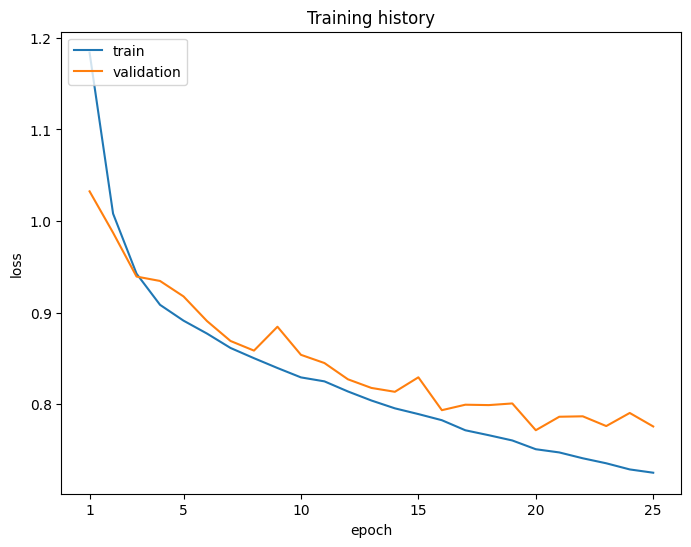

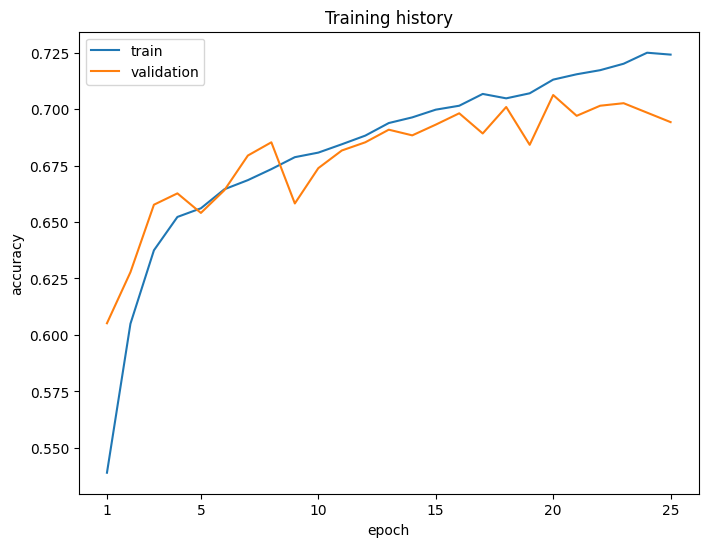

In [39]:
plot_history(history)

Load best model

In [41]:
model = keras.models.load_model("./models/big_custom/big_custom_20-0.7062.hdf5")
pred = model.predict(img_test, steps=len(img_test.filenames))

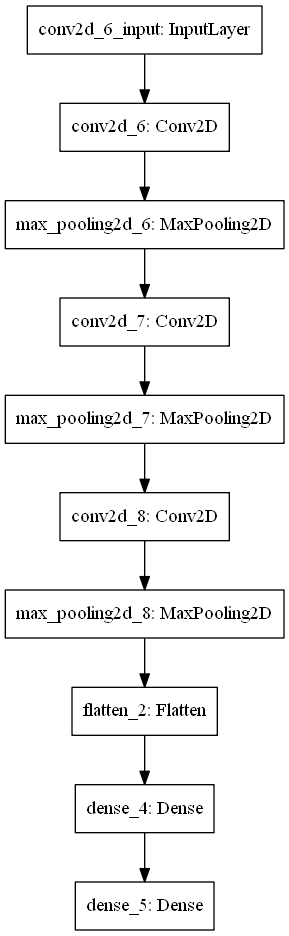

In [42]:
keras.utils.plot_model(model)

In [43]:
evaluate_classification_result(img_test.classes, pred,classes=["foggy","cloudy","sunny","snowy","rainy"])

[[648  80  31 120 461]
 [108  17   6  28  93]
 [197  23   9  35 121]
 [181  19  11  38 125]
 [602  75  29 129 419]]


Class foggy:
    Sensitivity (TPR):  48.358% (648 of 1340)
    Specificity (TNR):  51.965% (1177 of 2265)
    Precision:          37.327% (648 of 1736)
    Neg. pred. value:   62.975% (1177 of 1869)
Class cloudy:
    Sensitivity (TPR):   6.746% (17 of 252)
    Specificity (TNR):  94.125% (3156 of 3353)
    Precision:           7.944% (17 of 214)
    Neg. pred. value:   93.070% (3156 of 3391)
Class sunny:
    Sensitivity (TPR):   2.338% (9 of 385)
    Specificity (TNR):  97.609% (3143 of 3220)
    Precision:          10.465% (9 of 86)
    Neg. pred. value:   89.315% (3143 of 3519)
Class snowy:
    Sensitivity (TPR):  10.160% (38 of 374)
    Specificity (TNR):  90.344% (2919 of 3231)
    Precision:          10.857% (38 of 350)
    Neg. pred. value:   89.677% (2919 of 3255)
Class rainy:
    Sensitivity (TPR):  33.413% (419 of 1254)
    Specificity (TNR):  65.972% (1551 of 

array([[648,  80,  31, 120, 461],
       [108,  17,   6,  28,  93],
       [197,  23,   9,  35, 121],
       [181,  19,  11,  38, 125],
       [602,  75,  29, 129, 419]], dtype=int64)